In [31]:
%cd /proj/azizpour-group/users/x_amime/projects/an_explanation_model

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_3 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)

os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

In [33]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "layer_randomization",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)
project_metadata.drop_duplicates(inplace=True)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'layer_randomization', 'dataset', 'image_index', 'image_path',
       'input_shape', 'num_classes', 'seed', 'batch_size', 'max_batches',
       'min_change', 'metadata_file_path'],
      dtype='object')
(3111, 24)


In [34]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
layer_randomizations = project_metadata.index.get_level_values("layer_randomization").unique()

stream_name            stream_statistic  image_index  layer_randomization  alpha_mask_value
log_probs              meanx             0            Bottleneck_0         0.00                1
vanilla_grad_mask      meanx2            0            Bottleneck_0         0.16                1
results_at_projection  meanx             0            Dense_0              0.55                1
                                                                           0.56                1
                                                                           0.57                1
                                                                                              ..
                                                      Bottleneck_0         0.03                1
                                                                           0.04                1
                                                                           0.05                1
                                   

In [35]:
for name in project_metadata.index.names:
    print(
        name,
        "=",
        project_metadata.index.get_level_values(name).value_counts().to_dict(),
    )

stream_name = {'log_probs': 1037, 'results_at_projection': 1037, 'vanilla_grad_mask': 1037}
stream_statistic = {'meanx': 2074, 'meanx2': 1037}
image_index = {0: 3111}
layer_randomization = {'Bottleneck_0': 183, 'Bottleneck_3': 183, 'Bottleneck_9': 183, 'Bottleneck_8': 183, 'Bottleneck_7': 183, 'Bottleneck_6': 183, 'Bottleneck_5': 183, 'Bottleneck_4': 183, 'Bottleneck_2': 183, 'Bottleneck_1': 183, 'Bottleneck_15': 183, 'Bottleneck_14': 183, 'Bottleneck_13': 183, 'Bottleneck_12': 183, 'Bottleneck_11': 183, 'Bottleneck_10': 183, 'Dense_0': 183}
alpha_mask_value = {0.0: 51, 0.31: 51, 0.33: 51, 0.34: 51, 0.35: 51, 0.36: 51, 0.37: 51, 0.38: 51, 0.39: 51, 0.4: 51, 0.41: 51, 0.42: 51, 0.43: 51, 0.44: 51, 0.45: 51, 0.46: 51, 0.47: 51, 0.48: 51, 0.49: 51, 0.5: 51, 0.51: 51, 0.52: 51, 0.53: 51, 0.54: 51, 0.55: 51, 0.56: 51, 0.5700000000000001: 51, 0.58: 51, 0.59: 51, 0.32: 51, 0.3: 51, 0.01: 51, 0.29: 51, 0.02: 51, 0.03: 51, 0.04: 51, 0.05: 51, 0.06: 51, 0.07: 51, 0.08: 51, 0.09: 51, 0.1: 51, 0.1

In [36]:
import functools

def preprocess_masks_ndarray(masks, preprocesses):
        for preprocess in preprocesses:
            masks = preprocess(masks)
        return masks

def spectral_lens_generic(data, func, perprocess):
    init_val = np.load(data.iloc[0]["grad_mask"])
    init_val = preprocess_masks_ndarray(init_val, preprocesses=perprocess)

    for id, row in data.iterrows():
        temp_grad = np.load(row["grad_mask"])
        temp_grad = preprocess_masks_ndarray(temp_grad, preprocesses=perprocess)
        init_val = func(init_val, temp_grad)

    assert init_val.ndim == 3, f"{init_val.shape} must be 4d (H,W,C)"

    return init_val


def spectral_lens_max(data):
    grad_max = spectral_lens_generic(data, np.maximum, [sum_channels])
    return grad_max


def running_sum(init_val, temp_grad):
    return init_val + temp_grad


def div_by_sum(grad_mask, grad_sum):
    return grad_mask / grad_sum


def spectral_lens_sum(data):
    grad_sum = spectral_lens_generic(data, running_sum, [sum_channels])
    grad_sum = np.expand_dims(grad_sum, axis=0)
    return grad_sum


def spectral_lens_mean_freq(data):
    def func(init_val, temp_grad, frequency):
        return init_val + temp_grad * frequency**(3/2) # frequency \approx frequency^(3/2)

    grad_sum = spectral_lens_generic(data, running_sum, [sum_channels])
    div_by_sum_internal = functools.partial(div_by_sum, grad_sum=grad_sum)
    perprocess = [sum_channels, div_by_sum_internal]

    init_val = np.load(data.iloc[0]["grad_mask"])
    init_val = np.zeros_like(sum_channels(init_val))

    for id, row in data.iterrows():
        temp_grad = np.load(row["grad_mask"])
        temp_grad = preprocess_masks_ndarray(temp_grad, preprocesses=perprocess)
        init_val = func(init_val, temp_grad, row["alpha_mask_value"])

    assert init_val.ndim == 3, f"{init_val.shape} must be 4d (H,W,C)"
    init_val = np.expand_dims(init_val, axis=0)
    return init_val

In [37]:
image_index = 0
explanations_temp = project_metadata.loc[
    ("vanilla_grad_mask", "meanx2", image_index, slice(None), slice(None)), "data_path"
]
explanations_temp = explanations_temp.droplevel(
    ["stream_name", "image_index", "stream_statistic"]
)
explanations_temp.name = "grad_mask"
explanations_temp.sort_index(inplace=True)
explanations_temp = explanations_temp.reset_index()

explanations_mean_freq = explanations_temp.groupby(
    "layer_randomization", as_index=False
).apply(spectral_lens_mean_freq)

2024-01-20 15:04:47.597248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-20 15:04:47.597568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: berzelius1.nsc.liu.se
2024-01-20 15:04:47.597582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: berzelius1.nsc.liu.se
2024-01-20 15:04:47.597811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-01-20 15:04:47.597846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-01-20 15:04:47.597852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5
2024-01-20 15:04:47.824438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start 

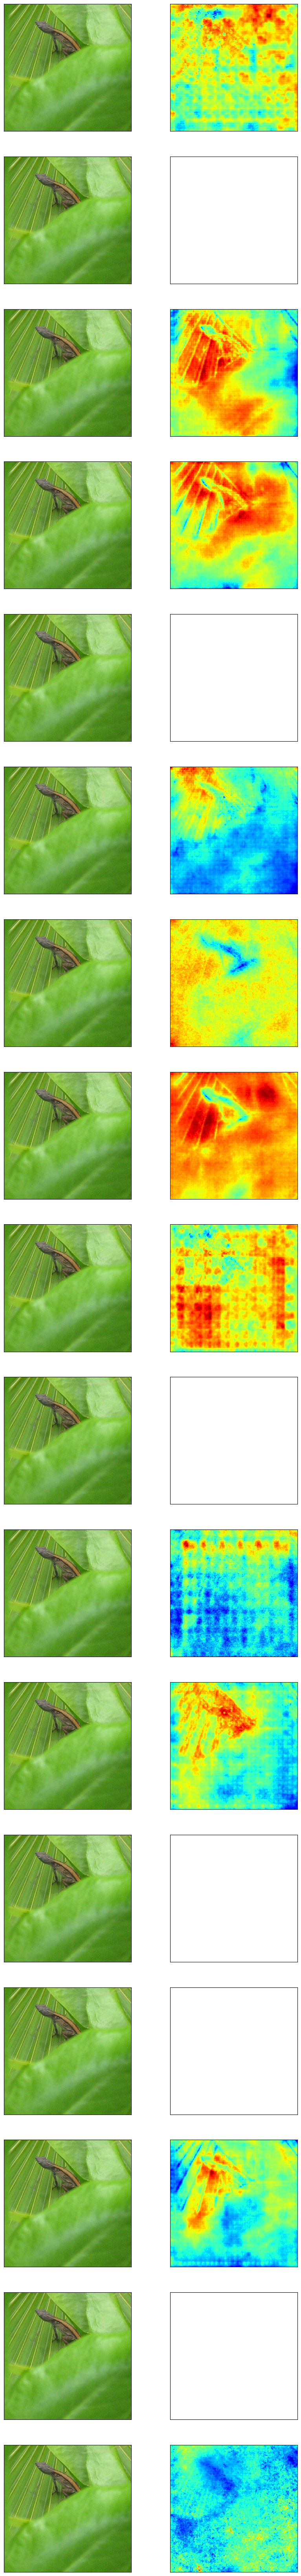

In [38]:
n_cols = 2
n_rows = len(layer_randomizations)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
)
axes = axes.flatten()
i = 0
names = []
for layer_randomization, explanation_mean_freq in zip(layer_randomizations, explanations_mean_freq):
    if i >= axes.size:
        break
    original_image, label, image_path = query_imagenet(image_index=image_index)

    axes[i].imshow(np.squeeze(original_image))
    clean_label = IMAGENET_LABELS[label]
    clean_label = clean_label.split(",")[0]
    # axes[i].set_title(f"label: {clean_label}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    names.append(f"image_index {image_index} original image ({clean_label})")

    explanation_mean_freq = minmax_normalize(explanation_mean_freq)
    axes[i + 1].imshow(explanation_mean_freq.squeeze(), cmap="jet")
    # axes[i + 1].set_title("mean frequency")
    axes[i + 1].set_xticks([])
    axes[i + 1].set_yticks([])
    names.append(f"image_index {image_index} randomized {layer_randomization} mean frequency ({clean_label})")

    # explanation_negentropy = minmax_normalize(explanation_negentropy)
    # axes[i+2].imshow(explanation_negentropy.squeeze(), cmap="jet")
    # axes[i+2].set_title("negative entropy")
    # names.append(f"image_index {image_index} negative entropy")

    i += 2

save_axis(names=names, fig=fig, axes=axes, save_output_dir=save_output_dir)

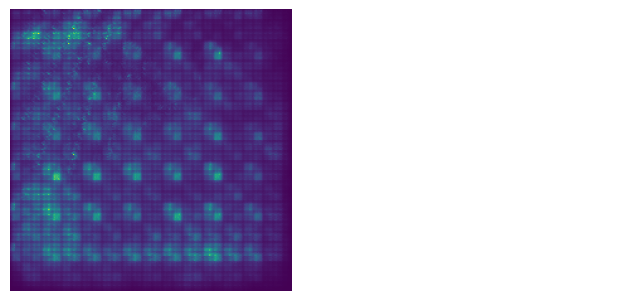

In [30]:
temp_masks = explanations_temp.set_index(["layer_randomization", "alpha_mask_value"])
temp_masks = temp_masks.loc[(slice(None), 0.2),"grad_mask"]
titles = temp_masks.index.to_series().apply(lambda x: f"layer_randomization {x[0]} alpha {x[1]:.2f}")
temp_masks=temp_masks.apply(np.load)
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
imshow_args = {"cmap": "viridis"}
fig, axes = plot_masks(temp_masks, imshow_args=imshow_args, ncols=2)
save_axis(titles, fig, axes, save_output_dir)